In [211]:
%matplotlib inline

import json
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding, Isomap
from MulticoreTSNE import MulticoreTSNE
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA, SparsePCA
import umap
from scipy.sparse import vstack
import pandas as pd
from gb_writer import GlyphboardWriter
# from sklearn.model_selection import GridSearchCV
from typing import Any
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import spacy
from spacy.lang.de.stop_words import STOP_WORDS


nlp = spacy.load('de')

In [206]:
# Classifiers
SGD = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3,
                    random_state=42, max_iter=5, tol=None)
MNB = MultinomialNB()
LR = LogisticRegression()
SVC = LinearSVC()
KNC = KNeighborsClassifier()
NC = NearestCentroid()
RFC = RandomForestClassifier()

vec = TfidfVectorizer(strip_accents='ascii', max_df=0.5, sublinear_tf=True)
SPLICE_POINT = 800
UNLABELED_VALUE = -1

def initData():
    texts = []
    labels = []
    ids = []
    peer_labels = []
    with open("test_data.json", "r") as read_file:
        LC_data = json.load(read_file)

    for doc in LC_data:
        ids.append(doc['id'])
        texts.append(doc["values"]["7"])
        peer_labels.append(doc["features"]["1"]["4"])
        # simulate all as labeled (for test_data)
        if (doc["features"]["1"]["4"] > 0.5):
            labels.append(1)
        else:
            labels.append(0)

    df = pd.DataFrame({
        'id': ids,
        'text': texts,
        'label': labels,
        'peer_label': peer_labels,
        'score': [0] * len(LC_data),
        'isLabeled': [False]  * len(LC_data)
    })
   
    test_data = df[SPLICE_POINT+1:]
    test_data.to_csv('test_data.csv', sep=";", encoding="utf8", index=False)
    
    data_with_scores = getSelectionScores()
    data_with_scores.to_csv('data.csv', sep=";", encoding="utf8", index=False)
    # resetTrainData()

def loadData():
    return pd.read_csv('data.csv', sep=";", encoding="utf8")

def handleNewAnswer(answer):    
    newAnswer = {
        'text': answer['text'],
        'docId': answer['documentId'],
        'label': int(answer['answer']),
        'question': answer['questionId']
    }
    train_data = getTrainData()

    test_data = getTestData()
    
    data = updateDataWithLabel(newAnswer['docId'], newAnswer['label'])
    data = loadData()
    if len(train_data) > 3:
        tfidf = vec.fit_transform(data.text)
        positions = applyDR(tfidf, data.label)
        train_result = train(train_data, test_data, SGD)
        return {
            'positions': positions,
            'train_result': train_result
        }
    else:
        return ''

def updateDataWithLabel(docId, label):
    data = loadData()
    print('before', data.loc[data['id'] == docId])
    data.loc[data['id'] == docId, 'label'] = int(label)
    data.loc[data['id'] == docId, 'isLabeled'] = True
    print('after', data.loc[data['id'] == docId])
    data.to_csv('data.csv', sep=";", encoding="utf8", index=False)

    return data


def createMetrics(algo):
    test_data = getTestData()
    train_data_df = getTrainData()
    train_data_df.label = train_data_df.label.astype(int)
    met = []
    # Create stepwise metrics algo, simulating a history
    for number in range(30, len(train_data_df)):
        train_data_iteration = train_data_df.head(number)
        met.append(train(train_data_iteration, test_data, algo=algo))
    return pd.DataFrame(met)


def train(train_data, test_data, algo: Any) -> dict:
    text_clf = Pipeline([
        # ('vect', CountVectorizer()),
        ('tfidf', vec),
        ('clf', algo),
    ])
    text_clf.fit(train_data.text, train_data.label)
    predicted = text_clf.predict(test_data.text)
    addHistory(metrics.f1_score(test_data.label, predicted))
    result = {
        'precision': metrics.precision_score(test_data.label, predicted),
        'recall': metrics.recall_score(test_data.label, predicted),
        'f1': metrics.f1_score(test_data.label, predicted),
        'f1_history': getHistory()
    }
    return result

def getTrainData():
    data = loadData()
    return data.loc[data['isLabeled'] == True]

def getTestData():
    return pd.read_csv('test_data.csv', delimiter=';', encoding="utf8")

def resetTrainData():
    data = loadData()
    data.loc[:, 'label'] = UNLABELED_VALUE
    data.to_csv('data.csv', sep=";", encoding="utf8", index=False)

def cleanupTexts():
    data = loadData()
    for idx, text in enumerate(data.text):
        data.loc[idx, 'text'] = preprocessText(text)
        
    data.to_csv('data.csv', sep=";", encoding="utf8", index=False)

def mockTraining(amount):
    data = loadData()
    for i in range(amount):
        data.loc[i, 'isLabeled'] = True
        if data.loc[i].peer_label > 0.5:
            data.loc[i, 'label'] = 1
        else:
            data.loc[i, 'label'] = 0        
    data.to_csv('data.csv', sep=";", encoding="utf8", index=False)

def simulateTraining(iterations):
    test_data = getTestData()
    mockTraining(iterations)
    train_data = getTrainData()
    train(train_data, test_data, SGD)

def getHistory():
    history = []
    with open(
            "metrics.csv", "r", encoding="utf8") as file:
        reader = csv.reader(file, delimiter=';')
        for line in reader:
            history.append(line[0])
        file.close()
    return history


def addHistory(metrics):
    with open(
            "metrics.csv", "a",  newline="", encoding="utf8") as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow([str(metrics)])
        file.close()

def getCurrentScore() -> int:
    return getHistory().pop()

def applyDR(tfidf, labels = []):    
    # pre_computed = TruncatedSVD(n_components=100, random_state=1).fit_transform(tfidf.toarray())
    # LABEL_IMPACT = 0
    labels_arr = np.asarray(labels)
    labels_arr = labels_arr.reshape(len(labels_arr), 1)
    # with_labels = np.hstack((tfidf.toarray(), labels_arr))
    computed_coords = umap.UMAP(min_dist=0.8, random_state=1).fit(tfidf.toarray())
    computed_coords = computed_coords.embedding_
    # computed_coords = MulticoreTSNE(n_jobs=4, random_state=1).fit_transform(with_labels)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = computed_coords[:, 0]
    df['y'] = computed_coords[:, 1]

    writer = GlyphboardWriter('test_name')

    # DR *= 2
    print('Writing positions...')    
    positions = writer.write_position(df, 'lsi')
    return positions

def preprocessText(text: str) -> str:
    # print('Original: ', text)
    doc = nlp(text)
    # Remove Stop Words and get Lemmas
    return ' '.join([token.text for token in doc if not token.is_stop])
    # for word in doc:
    #     if word.is_stop == True:
    #         print('Stop %s', word)
    # print(word.lemma_)

#             # Get NER
#     for ent in doc.ents:
#         print(ent.text, ent.start_char, ent.end_char, ent.label_)

def getSelectionScores(clf = MNB, rest_data = loadData(), train_data = getTestData()): 
    text_clf = Pipeline([
        # ('vect', CountVectorizer()),
        ('tfidf', vec),
        ('clf', clf),
    ])
    text_clf.fit(train_data.text, train_data.label)
    prs = text_clf.predict_proba(rest_data.text) 
    result_pos = [1-2*abs(x[1]-0.5)  for x in prs]
    rest_data['score'] = result_pos
    return rest_data

In [217]:
tfidf = vec.fit_transform(data.text)

positions = applyDR(tfidf)

with open("mainTfIdf.05112018.position.umap.json", "w") as f:
            json.dump(positions, f)
# writer = GlyphboardWriter('test_name')

# positions = writer.write_position(positions=df, algorithm='umap')
    
positions

Writing positions...


[{'id': 1, 'position': {'x': 0.6249691247940063, 'y': -4.90634298324585}},
 {'id': 2, 'position': {'x': -2.308318614959717, 'y': -1.4274338483810425}},
 {'id': 3, 'position': {'x': -5.13614559173584, 'y': -3.179719924926758}},
 {'id': 4, 'position': {'x': -1.6145720481872559, 'y': -1.850534200668335}},
 {'id': 5, 'position': {'x': 0.16646239161491394, 'y': -1.4290859699249268}},
 {'id': 6, 'position': {'x': -2.0143189430236816, 'y': -5.063178539276123}},
 {'id': 7, 'position': {'x': -2.9567151069641113, 'y': -6.772573947906494}},
 {'id': 8, 'position': {'x': -5.084327220916748, 'y': -3.5889673233032227}},
 {'id': 9, 'position': {'x': -5.090847969055176, 'y': -1.312164306640625}},
 {'id': 10, 'position': {'x': 0.7129210233688354, 'y': -6.650458812713623}},
 {'id': 11, 'position': {'x': -3.9433505535125732, 'y': -5.502143383026123}},
 {'id': 12, 'position': {'x': -3.2945311069488525, 'y': 0.30235108733177185}},
 {'id': 13, 'position': {'x': -1.2098406553268433, 'y': -7.636874675750732}},

In [226]:
data = loadData()
data.iloc[197]

id                          198
isLabeled                  True
label                         1
peer_label                    0
score                  0.858746
text          CLASSIC-CAR-MEET 
Name: 197, dtype: object

In [168]:
data = loadData()
response = data[['isLabeled', 'label', 'score']]
# json.dumps(response.to_json())
# response

In [9]:
# lsi = TruncatedSVD(n_components=2, random_state=1).fit_transform(tfidf.toarray())
# lsi = PCA(n_components=10, random_state=1).fit_transform(tfidf.toarray())

labels = np.asarray(data.label)
labels = labels.reshape(len(labels), 1)
# with_labels = np.hstack((lsi,labels))
with_labels = np.hstack((tfidf.toarray(),labels))


# m = Sequential()
# m.add(Dense(512,  activation='elu', input_shape=(101,)))
# m.add(Dense(128,  activation='elu'))
# m.add(Dense(2,    activation='linear', name="bottleneck"))
# m.add(Dense(128,  activation='elu'))
# m.add(Dense(512,  activation='elu'))
# m.add(Dense(101,  activation='sigmoid'))
# m.compile(loss='mean_squared_error', optimizer = Adam())
# history = m.fit(with_labels, with_labels, batch_size=128, epochs=5, verbose=1)

# encoder = Model(m.input, m.get_layer('bottleneck').output)
# lsi_with_labels = encoder.predict(with_labels)

# lsi_with_labels = PCA(n_components=2, random_state=1).fit_transform(with_labels)
# lsi_with_labels = TruncatedSVD(n_components=2, random_state=1).fit_transform(with_labels)
# lsi_with_labels = Isomap(n_components=2).fit_transform(with_labels)
# lsi_with_labels = MulticoreTSNE(n_jobs=1, n_components=2, random_state=1).fit_transform(with_labels)
# lsi_with_labels = LocallyLinearEmbedding(n_jobs=4,n_components=2, random_state=1).fit_transform(with_labels)
lsi_with_labels = umap.UMAP(random_state=1).fit_transform(with_labels)
df = pd.DataFrame(columns=['x', 'y'])
df['x'] = lsi_with_labels[:, 0]
df['y'] = lsi_with_labels[:, 1]
    
    
df *= 1
# DR.x *= 500
# DR.y *= 500

# print(df)

writer = GlyphboardWriter('test_name')

# DR *= 2
print('Writing positions...')    
writer.write_position(df, 'lsi')
del df
print('done')

Writing positions...
done


In [146]:
data = loadData()
train_data = getTrainData()
text_clf = Pipeline([
    # ('vect', CountVectorizer()),
    ('tfidf', vec),
    ('clf', MNB),
])
text_clf.fit(train_data.text, train_data.label)
prs = text_clf.predict_proba(data.text) 
result_pos = [1-2*abs(x[1]-0.5)  for x in prs]
data['score'] = result_pos
data.sort_values(by=['score'], ascending=False)

,id,label,peer_label,score,text
116,117,1,1.000000,0.999912,William Engelen : Kompositionen Streichquartet...
1059,1060,-1,0.032258,0.999305,The Jordan Bleu Blues Ninjas
876,877,-1,1.000000,0.998853,Limettenalarm Santa Edition IQ Wenn Leben Lime...
770,771,-1,0.935484,0.997989,Bohemian Blues Band feat . Jiri Marsicek Die J...
529,530,-1,1.000000,0.994535,The Tiger Lillies THE VERY WORST OF THE TIGER ...
618,619,-1,0.000000,0.994288,"WÜRZBURG Gift ! In Kriminalstück "" Ein Fremder..."
698,699,-1,0.093750,0.993615,Eifeleck präsentiert ; Arctic Winter Live ...
526,527,-1,0.967742,0.991350,REKK ( DUO ) ( live ) @ Café Käthe „ Die Dortm...
495,496,1,1.000000,0.984618,Forum junger Instrumentalisten Mittwoch 21.01....
826,827,-1,1.000000,0.984584,Oktoberfest Live Musik gespielt Musikern Neuen...


In [91]:
mockTraining(3)

In [63]:
data = loadData()
data.loc[:, 'label'] = -1
data.to_csv('data.csv', sep=";", encoding="utf8", index=False)

In [130]:
# resetTrainData()
# mockTraining(500)
# SGD_met = createMetrics(SGD)
# MNB_met = createMetrics(MNB)
# KNC_met = createMetrics(KNC)
# NC_met = createMetrics(NC)
RFC_met = createMetrics(RFC)
# getTrainData()


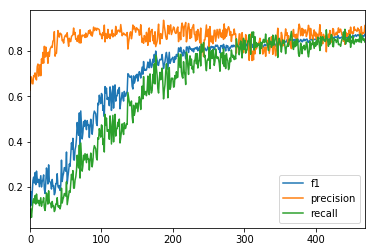

In [116]:
SGD_met.plot()

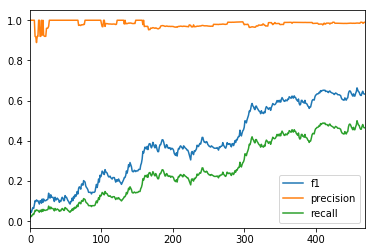

In [117]:
MNB_met.plot()

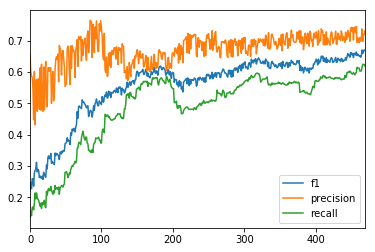

In [122]:
KNC_met.plot()

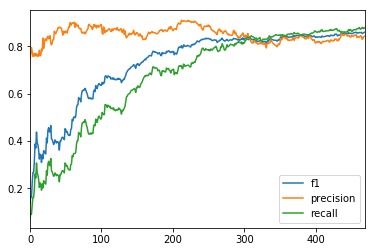

In [126]:
NC_met.plot()

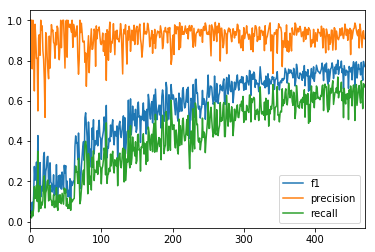

In [131]:
RFC_met.plot()